In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import empyrical
from WindPy import w
%matplotlib inline

In [54]:
w.start()

.ErrorCode=0
.Data=[Already conntected!]

In [55]:
def metric(ret):
    an_ret = empyrical.annual_return(ret, period='monthly')
    vol = empyrical.annual_volatility(ret, period='monthly')
    maxdraw = empyrical.max_drawdown(ret)
    print('Annual return: %.2f%%'%(an_ret*100))
    print('Sharpe ratio: %.2f'%(an_ret / vol))
    print('Annual volatility: %.2f%%'%(vol*100))
    print('Max drawdown: %.2f%%'%(maxdraw*100))

# 读取数据

In [56]:
wind = pd.read_excel('../data/wind.xlsx', index_col=0)

In [57]:
wind.tail()

,Wind Index,Wind Index PE
881001.WI,,
2019-07-31,4041.1186,16.937901
2019-08-30,4011.1518,16.622400
2019-09-30,4042.0189,16.859600
2019-10-31,4075.0093,16.699699
2019-11-30,4013.6018,16.460600


In [58]:
df = pd.read_excel(u'../data/global strategy data.xlsx', sheet_name='data', index_col=0)

In [59]:
df.tail()

,SHCOMP Index,HSI Index,SPXT Index,LUATTRUU Index,CNDR1Y index,SHCOMP Index PE,HSI Index PE,SPX Index PE,FDTRMID Index
1997-12-31 00:00:00,,,,,,,,,
2019-07-31,616.6612,49227.2351,41258.18091,2329.893,1.5,14.0091,11.9095,19.5551,2.125
2019-08-30,584.5211,47486.8305,42211.86264,2409.096,1.5,13.8609,10.9954,19.2503,2.125
2019-09-30,589.7056,48332.0945,42951.80476,2388.719,1.5,13.7978,11.0685,19.7391,1.875
2019-10-31,603.8401,49162.9115,43208.67885,2390.346,1.5,13.9336,11.4012,20.1519,1.625
2019-11-30,592.6494,48209.2480,44738.30686,2383.156,1.5,13.6646,11.1607,20.8877,1.625


In [60]:
df = df.merge(wind, left_index=True, right_index=True)

In [61]:
a_stock, hk_stock, us_stock = 'Wind Index', 'HSI Index', 'SPXT  Index'
asset_columns = [a_stock, hk_stock, us_stock, 'LUATTRUU Index']

In [62]:
assets_ret = df[asset_columns].pct_change()

In [63]:
fed_rate = df['FDTRMID Index']

In [64]:
assets_ret.head()

,Wind Index,HSI Index,SPXT Index,LUATTRUU Index
1999-12-31,NaN,NaN,NaN,NaN
2000-01-31,0.160787,-0.085760,-0.050449,0.002609
2000-02-29,0.122079,0.105179,-0.018823,0.015038
2000-03-31,0.055354,0.018554,0.097842,0.019860
2000-04-28,0.012971,-0.106297,-0.029946,-0.003167


# 计算估值偏离

In [65]:
pe = df[['Wind Index PE', 'HSI Index PE', 'SPX Index PE']]

In [83]:
pe_dev = (pe - pe.rolling(60).mean()) / pe.rolling(60).mean()

In [84]:
pe_dev = pe_dev.dropna()

# 回测

In [86]:
# 判断当前状态
def regime_weight(date):
    rate_change = fed_rate[fed_rate.index <= date].diff(3).iloc[-1]
    if rate_change == 0:
        return np.array([0.3, 0.3, 0.3, 0.1])
    elif rate_change > 0:
        return np.array([1./3, 1./3, 1./3, 0.])
    else:
        return np.array([0.8/3, 0.8/3, 0.8/3, 0.2])

In [87]:
def weight_change(w, dev):
    if dev < -0.3:
        return w + 0.35
    elif -0.3 <= dev and dev < -0.2:
        return w + 0.25
    elif -0.2 <= dev and dev < -0.1:
        return w + 0.15
    elif 0.1 <= dev and dev < 0.2:
        return max(0, w - 0.15)
    elif 0.2 <= dev and dev < 0.3:
        return max(0, w - 0.25)
    elif dev >= 0.3:
        return max(0, w - 0.35)
    else:
        return w

In [88]:
def calc_weight(date):
#     print(date)
    w = regime_weight(date)
    current_pe_dev = pe_dev[pe_dev.index <= date].loc[date]
    
#     print(w)
    
    init_w = w[:3].sum()
    w[0] = weight_change(w[0], current_pe_dev['Wind Index PE'])
    w[1] = weight_change(w[1], current_pe_dev['HSI Index PE'])
    w[2] = weight_change(w[2], current_pe_dev['SPX Index PE'])
    
#     print(w)

    sum_w = w[:3].sum()
    w[0] = w[0] * init_w / sum_w
    w[1] = w[1] * init_w / sum_w
    w[2] = w[2] * init_w / sum_w
    
#     print(w)

    return w

In [89]:
assets_ret = assets_ret[assets_ret.index >= '2005-01-01']

In [90]:
weight = pd.DataFrame(columns=assets_ret.columns, index=assets_ret.index)
n = assets_ret.shape[1]
wb = np.zeros(n)

for date in weight.index:
    wb = calc_weight(date)
    weight.loc[date] = wb

In [91]:
portfolio = (weight.shift(1) * assets_ret).sum(axis=1)

In [92]:
portfolio.tail()

2019-07-31   -0.002166
2019-08-30    0.001448
2019-09-30    0.008942
2019-10-31    0.008203
2019-11-30   -0.002295
dtype: float64

In [93]:
metric(portfolio)

Annual return: 10.50%
Sharpe ratio: 0.69
Annual volatility: 15.13%
Max drawdown: -49.40%


# 业绩对比

In [94]:
data = w.wsd('000001.SH, CBA00101.CS, HSI.HI,SPX.GI', 'pct_chg', assets_ret.index[0], assets_ret.index[-1], 'Period=M')

In [95]:
bdf = pd.DataFrame(np.array(data.Data).T/100, index=data.Times, columns=data.Codes)

In [96]:
bdf.iloc[0] = 0

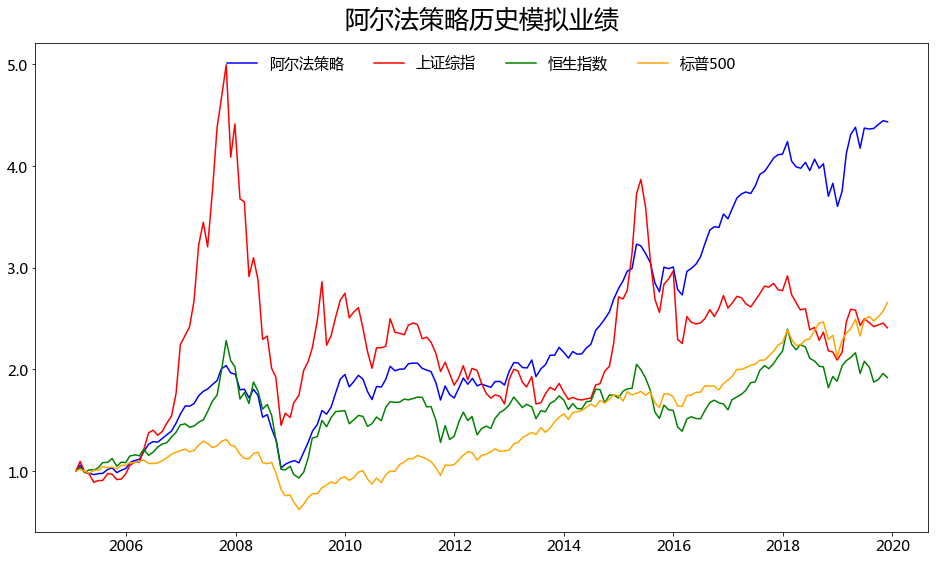

In [97]:
fig, ax = plt.subplots(figsize=(16, 9))

lns1 = ax.plot((1 + portfolio).cumprod(), color='blue', label=u'阿尔法策略')
lns2 = ax.plot((1 + bdf['000001.SH']).cumprod(), color='red', label=u'上证综指')
lns3 = ax.plot((1 + bdf['HSI.HI']).cumprod(), color='green', label=u'恒生指数')
lns4 = ax.plot((1 + bdf['SPX.GI']).cumprod(), color='orange', label=u'标普500')

lns = lns1 + lns2 + lns3 + lns4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, frameon=False, fontsize=15, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.0))

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.1f}'.format(x) for x in vals])

_ = ax.set_title(u'阿尔法策略历史模拟业绩', fontsize=25, y=1.02)

In [98]:
weight = weight.astype(np.float32)

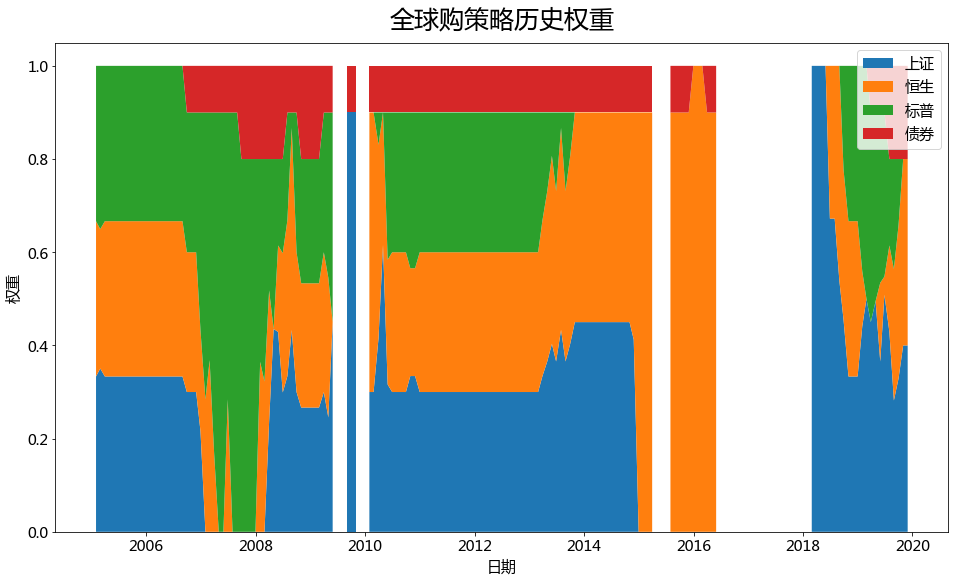

In [81]:
fig, ax = plt.subplots(figsize=(16, 9))
_ = ax.stackplot(weight.index, 
                 weight['Wind Index'],
                 weight['HSI Index'],
                 weight['SPXT  Index'],
                 weight['LUATTRUU Index'],
                 labels=[u'上证', u'恒生', u'标普', u'债券'])
ax.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylabel(u'权重', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)
_ = ax.set_title(u'全球购策略历史权重', fontsize=25, y=1.02)

In [34]:
weight.tail()

,Wind Index,HSI Index,SPXT Index,LUATTRUU Index
2019-07-31,0.350877,0.224561,0.224561,0.2
2019-08-30,0.350877,0.224561,0.224561,0.2
2019-09-30,0.350877,0.224561,0.224561,0.2
2019-10-31,0.350877,0.224561,0.224561,0.2
2019-11-30,0.350877,0.224561,0.224561,0.2


In [35]:
weight.to_excel('../data/weight.xlsx')